### First things first

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

from sklearn.naive_bayes import MultinomialNB


In [ ]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
df = pd.read_csv('train.csv').drop(columns = 'id')
df.head()

,text,is_humor,humor_rating,humor_controversy,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [ ]:

bins = [0.0,1.0,2.0,3.0,4.0,5.0]
df['humor_rating_class'] = pd.cut(df['humor_rating'], bins)
dfr = df[df['is_humor']==1]

In [ ]:
dd = df.iloc[0,5]

print(dd.left)


2.0


(0.0, 1.0]
	 (97, 6)
(1.0, 2.0]
	 (1548, 6)
(2.0, 3.0]
	 (2873, 6)
(3.0, 4.0]
	 (414, 6)
(4.0, 5.0]
	 (0, 6)


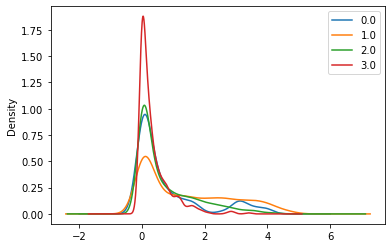

In [ ]:
for k,v in dfr.groupby('humor_rating_class'):
    print(k)
    print("\t",v.shape)
    if v.shape[0]>1:
        v.offense_rating.plot.kde(0.2,label=k.left,legend=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['text']], df['is_humor'], test_size = 0.2, random_state = 21)

In [ ]:
X_train.describe()

,text
count,6400
unique,6400
top,Me: Ever seen someone write a check with 9 zer...
freq,1


In [ ]:
total = len(y_train)
print('% of positives is ', round(y_train.sum()/total, 2)) #'% of positives is {:.2f}'.format(y_train.sum()/total)
print('% of negatives is ', round((total - y_train.sum())/total, 2)) #'% of negatives is {:.2f}'.format((total - y_train.sum())/total)

% of positives is  0.61
% of negatives is  0.39


(array([2466.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3934.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

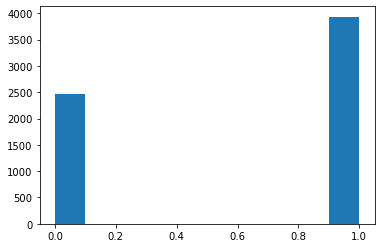

In [ ]:
plt.hist(y_train)

In [ ]:
def stemmer(text, stemmer):
    return(' '.join([stemmer.stem(w) for w in word_tokenize(text)]))

def count_words(input):
    """ Returns number of occurences of characters specified in char """     
    return len(input.split())

def remove_punctuation(s_input, include_char = None):
    """ Returns input string without punctuation """
    import string as String
    punct = String.punctuation
    
    if not include_char is None:
        index = String.punctuation.index(include_char)
        punct = String.punctuation[:index] + String.punctuation[(index + 1):]
        
    punct += '\n'
        
    translator = str.maketrans(punct, ' '*len(punct))
    
    return s_input.translate(translator)

def remove_stopwords(text, use_stopwords = None, df = True, exclude_number = True):
    """ Returns input string removing stopwords from it. """
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    
    if use_stopwords is None:
        use_stopwords = set(stopwords.words("english"))
        
    if df:
        new_text = word_tokenize(text)
        if exclude_number:
            new_text = [word for word in new_text if not word.isnumeric()]
        new_text = " ".join([word for word in new_text if word not in use_stopwords])
    else:
        new_text = ""
        for word in text:
            if word not in use_stopwords:
                new_text += word + " "

    return new_text

def sep_upper(text):
    """ Take a text as input and insert space before every uppercase letter. """
    
    new_text = ""
    for letter in text:
        if letter.isupper():
            new_text += " " + letter
        else:
            new_text += letter
    
    return new_text

def remove_space(text):
    return(re.sub(' +',' ',text)) 

def pre_proc(text_col):
    text_col = text_col.apply(remove_punctuation) # removes String.punctuation characters
    #text_col = text_col.apply(remove_stopwords)   # removes english stopwords 
    text_col = text_col.str.replace('[^\w\s]','').str.strip() # and removes whitespaces
    text_col = text_col.apply(sep_upper) # adds space before an uppercase
    text_col = text_col.str.lower() # lowercase
    
    return text_col
X_train.text = pre_proc(X_train.text)
X_test.text = pre_proc(X_test.text)

In [ ]:
X_train['qtd_words'] = X_train.text.apply(count_words)
X_test['qtd_words'] = X_test.text.apply(count_words)

In [ ]:
X_test.head()

,text,qtd_words
1705,like if i had information i could dismiss fro...,15
6185,since my wife left i ve bought a harley d...,36
899,there s a man walking a tight rope 100ft bel...,33
7453,my wife yelled at me saying you weren t ev...,26
2772,bipolar depression is technically referred to...,21


# additions by iago

In [ ]:
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

 1. add weight balancing
 2. check other classification models: logistic regression, svc, gaussian NB
 3. apply grid search to for mnb and logit
 4. register and compare the accuracy and other metrics per model
 

In [ ]:
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels,y= y_train)
class_weights = dict(zip(class_labels, class_weights))

In [ ]:
##%% this code didnt improve the baseline model

svc = SVC(max_iter=10000,tol=0.00001,random_state=42,class_weight=class_weights,probability=True) #,class_weight=class_weights
lr = LogisticRegression(max_iter=10000,tol=0.00001,class_weight=class_weights,random_state=42) #class_weight=class_weights,

gnb = GaussianNB()
mnb = MultinomialNB()

models ={'svc':svc,
         'lr':lr,
         #'gnb': gnb, #crashes for some unknown reason
         'mnb':mnb}

In [ ]:
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numerical_data = FunctionTransformer(lambda x: x[['qtd_words']], validate=False)

In [ ]:
dictResults = {}
for el in models.keys():
    print(el)
    process_and_join_features = Pipeline([('features', FeatureUnion([
        ('text_features', Pipeline([('selector', get_text_data), 
                                ('vec', CountVectorizer())])),
        ('nume_features', Pipeline([('selector', get_numerical_data), 
                                ('scaler', MinMaxScaler())]))
        ])),
        ('clf', models[el])
                                      ])
    process_and_join_features.fit(X_train, y_train)
    y_pred = process_and_join_features.predict(X_test)
    tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
    acc = (tn + tp)/y_test.size
    recall = tp/(tp + fn)
    fpr = fp/(fp + tn)
    prec = tp/(tp + fp)
    f1Score = 2*(recall*prec)/(recall + prec)
    print("\t-> acc: ",acc)
    print("\t-> recall: ",recall)
    print("\t-> prec: ",prec)
    print("\t-> f1-score: ",f1Score)
    dictResults[el] = [acc,recall,fpr,prec,tn,fp,fn,tp,f1Score]

svc
	-> acc:  0.833125
	-> recall:  0.8276553106212425
	-> prec:  0.8968512486427795
	-> f1-score:  0.8608650338718082
lr
	-> acc:  0.84625
	-> recall:  0.8517034068136272
	-> prec:  0.8966244725738397
	-> f1-score:  0.8735868448098664
mnb
	-> acc:  0.85125
	-> recall:  0.9138276553106213
	-> prec:  0.8571428571428571
	-> f1-score:  0.8845780795344325


In [ ]:
dfResults = pd.DataFrame(dictResults).transpose()
dfResults.columns = ['acc','recall','fpr','prec','tn','fp','fn','tp','f1-score']

bestModel = dfResults['acc'].idxmax()
print("model with best accuracy: ",bestModel)
dfResults.head()

model with best accuracy:  mnb


,acc,recall,fpr,prec,tn,fp,fn,tp,f1-score
svc,0.833125,0.827655,0.157807,0.896851,507.0,95.0,172.0,826.0,0.860865
lr,0.846250,0.851703,0.162791,0.896624,504.0,98.0,148.0,850.0,0.873587
mnb,0.851250,0.913828,0.252492,0.857143,450.0,152.0,86.0,912.0,0.884578


## report

1. Multinomial NB seems to be better than the other models, although Gaussian NB couldnt be tested
2. Grid search does not improve the results, in fact makes it worse
3. Tested also other metrics

## improve grid search
logistic regression is as good as multinomial NB, but has more options for hyperparameter optimization, therefore we will stick to logistic regression

In [ ]:

lr = LogisticRegression(max_iter=100000,tol=0.00001,class_weight=class_weights,random_state=42) #class_weight=class_weights,

parameters1 = {'penalty':['elasticnet'],'C':[100],'l1_ratio':[0,0.25,0.5,0.75,1],'fit_intercept':[True,False],'solver':['saga']}
parameters2 = {'penalty':['l1'],'C':[ 0.01,0.1,1,10,100],'solver':['liblinear']}
parameters3 = {'penalty':['l2'],'C':[ 0.01,0.1,1,10,100],'solver':['newton-cg', 'lbfgs',  'sag']}
parameters = parameters1
gridSearch = GridSearchCV(lr, param_grid=parameters, scoring='f1',verbose=5)

process_and_join_features = Pipeline([('features', FeatureUnion([
        ('text_features', Pipeline([('selector', get_text_data), 
                                ('vec', CountVectorizer())])),
        ('nume_features', Pipeline([('selector', get_numerical_data), 
                                ('scaler', MinMaxScaler())]))
        ])),
        ('clf', gridSearch)
                                      ])
import time
t0 = time.time()
process_and_join_features.fit(X_train, y_train)
print(time.time()-t0)

y_pred = process_and_join_features.predict(X_test)
tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
acc = (tn + tp)/y_test.size
recall = tp/(tp + fn)
fpr = fp/(fp + tn)
prec = tp/(tp + fp)
f1Score = 2*(recall*prec)/(recall + prec)
print("\t-> acc: ",acc)
print("\t-> recall: ",recall)
print("\t-> prec: ",prec)
print("\t-> f1-score: ",f1Score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=100, fit_intercept=True, l1_ratio=0, penalty=elasticnet, solver=saga 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100, fit_intercept=True, l1_ratio=0, penalty=elasticnet, solver=saga, score=0.837, total=  14.9s
[CV] C=100, fit_intercept=True, l1_ratio=0, penalty=elasticnet, solver=saga 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s


[CV]  C=100, fit_intercept=True, l1_ratio=0, penalty=elasticnet, solver=saga, score=0.856, total=   6.9s
[CV] C=100, fit_intercept=True, l1_ratio=0, penalty=elasticnet, solver=saga 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s


[CV]  C=100, fit_intercept=True, l1_ratio=0, penalty=elasticnet, solver=saga, score=0.858, total=  16.4s
[CV] C=100, fit_intercept=True, l1_ratio=0, penalty=elasticnet, solver=saga 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.1s remaining:    0.0s


[CV]  C=100, fit_intercept=True, l1_ratio=0, penalty=elasticnet, solver=saga, score=0.837, total=  14.9s
[CV] C=100, fit_intercept=True, l1_ratio=0, penalty=elasticnet, solver=saga 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   52.9s remaining:    0.0s


[CV]  C=100, fit_intercept=True, l1_ratio=0, penalty=elasticnet, solver=saga, score=0.864, total=  16.3s
[CV] C=100, fit_intercept=True, l1_ratio=0.25, penalty=elasticnet, solver=saga 
[CV]  C=100, fit_intercept=True, l1_ratio=0.25, penalty=elasticnet, solver=saga, score=0.835, total=25.2min
[CV] C=100, fit_intercept=True, l1_ratio=0.25, penalty=elasticnet, solver=saga 
[CV]  C=100, fit_intercept=True, l1_ratio=0.25, penalty=elasticnet, solver=saga, score=0.854, total=13.3min
[CV] C=100, fit_intercept=True, l1_ratio=0.25, penalty=elasticnet, solver=saga 
[CV]  C=100, fit_intercept=True, l1_ratio=0.25, penalty=elasticnet, solver=saga, score=0.858, total=27.9min
[CV] C=100, fit_intercept=True, l1_ratio=0.25, penalty=elasticnet, solver=saga 
[CV]  C=100, fit_intercept=True, l1_ratio=0.25, penalty=elasticnet, solver=saga, score=0.838, total=24.4min
[CV] C=100, fit_intercept=True, l1_ratio=0.25, penalty=elasticnet, solver=saga 
[CV]  C=100, fit_intercept=True, l1_ratio=0.25, penalty=elastic

KeyboardInterrupt: 

In [ ]:
process_and_join_features.fit(X_train, y_train)
predicted_CountVectorizer = process_and_join_features.predict(X_test)

In [ ]:
from sklearn import metrics

print(metrics.accuracy_score(y_test, predicted_CountVectorizer))

0.85125


In [ ]:
df.iloc[1705].text

'Like if i had information i could dismiss from my brain it would be this'

In [ ]:
X_test.loc[1705].text

' like if i had information i could dismiss from my brain it would be this'